# Bounding Box Model
This notebook explains how to generage a bounding box model.<br/>
While many of the whale pictures in the dataset are already cropped tight around the whale fluke, in some images the whale fluke occupies only a small area of the picture. Zooming in the relevant part of the picture provides greater accuracy to a classification model. To automate the process, this notebook explains how to construct a convolutional neural network (CNN) capable of estimating the whale bounding box.<br/>
Using this model, whale pictures can be cropped automatically to a more uniform appearance. This facilitates training of classification models, and improves the test accuracy.<br/>
Training of the bounding box model is performed over a dataset of 1200 bounding boxes for pictures selected from the Humpback Whale Identification Challenge training set. 1000 pictures are used for training, while 200 are reserved for validation.

https://www.kaggle.com/martinpiotte/bounding-box-model

In [1]:
# # Suppress annoying stderr output when importing tensorflow.tensorflow.keras.
# import sys
# old_stderr = sys.stderr
# sys.stderr = open('/dev/null', 'w')
# import tensorflow.keras
# sys.stderr = old_stderr

In [2]:
# ! https://www.kaggle.com/kernels/svzip/4346884

In [3]:
# !wget https://raw.githubusercontent.com/radekosmulski/whale/master/data/annotations.json

# Read the cropping dataset
Once decoded, the variable *data* is a list of tuples. Each tuple contains the picture filename and a list of coordinates.

In [4]:
with open('cropping.txt', 'rt') as f: data = f.read().split('\n')[:-1]
data = [line.split(',') for line in data]
data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]
data[0] # Show an example: (picture-name, [coordinates])

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [5]:
import pandas as pd
df = pd.read_json('annotations.json')

https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb

The coordinates represent points on the fluke edge. The extremum values can be used to construct a bounding box.

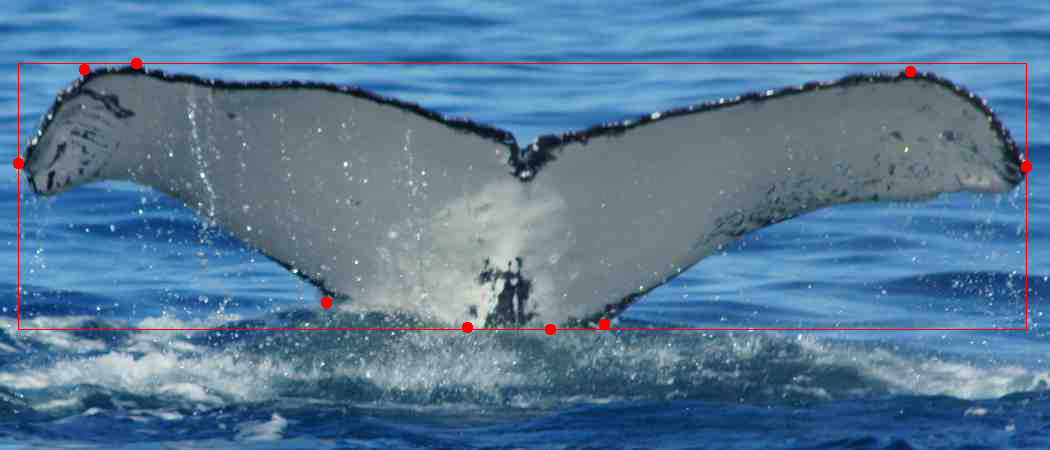

In [6]:
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from os.path import isfile

def expand_path(p):
    if isfile('train/' + p): return 'train/' + p
    if isfile('test/' + p): return 'test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

filename,coordinates = data[235]
box = bounding_rectangle(coordinates)
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
draw.rectangle(box, outline='red')
img

# Image preprocessing code
Images are preprocessed by:
1. Converting to black&white;
1. Compressing horizontally by a factor of 2.15 (the mean aspect ratio);
1. Apply a random image transformation (only for training)
1. Resizing to 128x128;
1. Normalizing to zero mean and unit variance.

These operation are performed by the following code that is later invoked when preparing the corpus.

In [7]:
# Define useful constants
img_shape  = ( 192, 384, 1)
anisotropy = 1

In [8]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from tensorflow.keras.preprocessing.image import img_to_array

# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

# Prepare the corpus
Split the corpus between training and validation data. Duplicate the training data 16 times to make reasonable size training epochs.

In [9]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=200, random_state=1)
train += train
train += train
train += train
train += train
len(train),len(val)

(16000, 200)

100%|██████████| 200/200 [00:02<00:00, 92.13it/s]


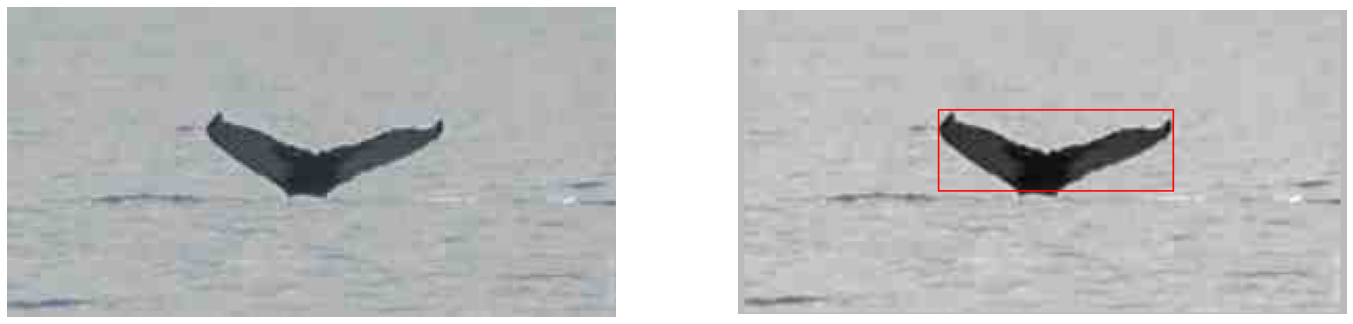

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img
from numpy.linalg import inv as mat_inv

def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

val_a = np.zeros((len(val),)+img_shape,dtype=K.floatx()) # Preprocess validation images 
val_b = np.zeros((len(val),4),dtype=K.floatx()) # Preprocess bounding boxes
for i,(p,coords) in enumerate(tqdm(val)):
    img,trans      = read_for_validation(p)
    coords         = coord_transform(coords, mat_inv(trans))
    x0,y0,x1,y1    = bounding_rectangle(coords)
    val_a[i,:,:,:] = img
    val_b[i,0]     = x0
    val_b[i,1]     = y0
    val_b[i,2]     = x1
    val_b[i,3]     = y1

idx  = 1
img  = array_to_img(val_a[idx])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(val_b[idx], outline='red')
show_whale([read_raw_image(val[idx][0]), img], per_row=2)

The image on the left side is the original image. The image on the right side is converted to B&W, compressed horizontally, padded and resized to 128x128.<br.>
The right side image is annotated with the transformed bounding box.

The following class extends the Sequence class from tensorflow.tensorflow.keras to generate input image data augmentation on the fly. Each image is processed through a random affine transformation. The tagged boundary points are also transformed to adjust the dimension of the bounding box.

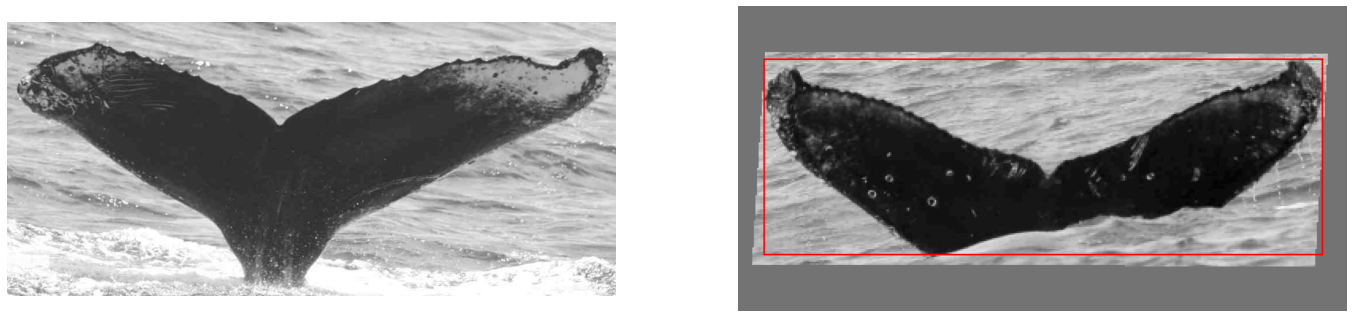

In [11]:
from tensorflow.keras.utils import Sequence

class TrainingData(Sequence):
    def __init__(self, batch_size=16):
        super(TrainingData, self).__init__()
        self.batch_size = batch_size
    def __getitem__(self, index):
        start = self.batch_size*index;
        end   = min(len(train), start + self.batch_size)
        size  = end - start
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,4), dtype=K.floatx())
        for i,(p,coords) in enumerate(train[start:end]):
            img,trans   = read_for_training(p)
            coords      = coord_transform(coords, mat_inv(trans))
            x0,y0,x1,y1 = bounding_rectangle(coords)
            a[i,:,:,:]  = img
            b[i,0]      = x0
            b[i,1]      = y0
            b[i,2]      = x1
            b[i,3]      = y1
        return a,b
    def __len__(self):
        return (len(train) + self.batch_size - 1)//self.batch_size

random.seed(1)
a, b = TrainingData(batch_size=5)[1]
img  = array_to_img(a[0])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(b[0], outline='red')
show_whale([read_raw_image(train[0][0]), img], per_row=2)

The image on the left side is the original image. The image on the right side is converted to B&W, compressed horizontally, randomly transformed, padded and resized to 128x128.<br.>
The right side image is annotated with the transformed bounding box.

# tensorflow.tensorflow.keras Model
The following code fragment shows the bounding box model construction.

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model

def build_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=img_shape)

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)

model = build_model(with_dropout=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 384, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 384, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 384, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

Here are a few thoughts aboud the model:

 * The basic idea is mostly inspired from the VGG model, with a stack of 3x3 convolutions separated by pooling layers. Here max pooling is replaced by a 2x2 convolution with stride 2. It seemed more logical, as max pooling appears to lose some location information. In practice in makes little difference.
 * At the end, max pooling is used on rows and columns separately. For the fluke height, we don't care if it occurs on the left or right. Similarly for the width, we don't care if it occurs at the top or the bottom. Both sets are concatenated, but clearly one subset is aimed at finding left and right, and the other top and bottom.
 * A few changes from VGG include a larger kernel for the first convolution, batch normalization and dropout. 

The model is trained using data augmentation (random affine transformations) as generated by the TrainingData class defined above.<br/>
Decreasing learning rate and early stopping is used when no significant progress is made.<br/>
The model is trained three times. The weights are preserved between runs, but the learning rate is reset to the original value. This essentially cycles the learning rate between low and high values, which can be advantageous according to **Smith, L.N.**,  "*Cyclical Learning Rates for Training Neural Networks*", [arXiv:1506.01186](https://arxiv.org/abs/1506.01186).

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

for num in range(1, 4):
    model_name = 'cropping-%01d.h5' % num
    print(model_name)
    model.compile(Adam(lr=0.032), loss='mean_squared_error')
    model.fit_generator(
        TrainingData(), epochs=50, max_queue_size=12, workers=4, verbose=1,
        validation_data=(val_a, val_b),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25, min_lr=0.002, verbose=1),
            ModelCheckpoint(model_name, save_best_only=True, save_weights_only=True),
        ],
        validation_freq=1)
    model.load_weights(model_name)
    model.evaluate(val_a, val_b, verbose=0)

cropping-1.h5
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1000 steps, validate on 200 samples
Epoch 1/50
1000/1000 [==============================] - 389s 389ms/step - loss: 3624.9507 - val_loss: 1063.1815
Epoch 2/50
1000/1000 [==============================] - 385s 385ms/step - loss: 2572.5130 - val_loss: 666.3222
Epoch 3/50
1000/1000 [==============================] - 385s 385ms/step - loss: 2187.6825 - val_loss: 963.5934
Epoch 4/50
1000/1000 [==============================] - 385s 385ms/step - loss: 1895.7848 - val_loss: 438.1335
Epoch 5/50
1000/1000 [==============================] - 385s 385ms/step - loss: 1584.4145 - val_loss: 641.8730
Epoch 6/50
1000/1000 [==============================] - 385s 385ms/step - loss: 1387.1894 - val_loss: 499.8586
Epoch 7/50
 999/1000 [============================>.] - ETA: 0s - loss: 1352.2820
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00800000037997961.
1000/1000 [=

KeyboardInterrupt: 

In [ ]:
fg

Select the best of the three attempts.

In [14]:
model.load_weights('cropping-1.h5')
loss1 = model.evaluate(val_a, val_b, verbose=0)
# model.load_weights('cropping-2.h5')
# loss2 = model.evaluate(val_a, val_b, verbose=0)
# model.load_weights('cropping-3.h5')
# loss3 = model.evaluate(val_a, val_b, verbose=0)
# model_name = 'cropping-1.h5'
# if loss2 <= loss1 and loss2 < loss3: model_name = 'cropping-2.h5'
# if loss3 <= loss1 and loss3 <= loss2: model_name = 'cropping-3.h5'
# model.load_weights(model_name)
# loss1, loss2, loss3, model_name

In [17]:
model_name = 'cropping-1.h5'

# Variance normalization
Using batch normalization after dropout has a small problem. During training, dropout zeros some outputs, but scales up the remaining ones to maintain the output average. However, the output **variance** is not preserved. The variance is larger during training than it is during inference.<br/>
Batch normalization also behaves differently during training and inference. During training batches are normalized, but at the same time a running average of batch mean and variance is computed. This running average is used as a sample estimate during inference. It should be immediately obvious that the running average value is not a good approximation of the sample variance during inference, because dropout behavior changes the variance.  See **Xiang Li, Shuo Chen, Xiaolin Hu, Jian Yang**, "*Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift*", [arXiv:1801.05134](https://arxiv.org/abs/1801.05134).<br/>
One of the proposed solutions is to recompute the batch normalization running average without dropout, while freezing other layers. The resulting accuracy is expected to be slightly better.

In [18]:
model2 = build_model(with_dropout=False)
model2.load_weights(model_name)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 192, 384, 64) 5248        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 192, 384, 64) 36928       conv2d_34[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 192, 384, 64) 256         conv2d_35[0][0]                  
____________________________________________________________________________________________

In [19]:
model2.compile(Adam(lr=0.002), loss='mean_squared_error')
model2.evaluate(val_a, val_b, verbose=0)

185.2952197265625

In [20]:
# Recompute the mean and variance running average without dropout
for layer in model2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False
model2.compile(Adam(lr=0.002), loss='mean_squared_error')
model2.fit_generator(TrainingData(), epochs=1, max_queue_size=12, workers=6, verbose=1, validation_data=(val_a, val_b))
for layer in model2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
model2.compile(Adam(lr=0.002), loss='mean_squared_error')

  ...
    to  
  ['...']
Train for 1000 steps, validate on 200 samples
1000/1000 [==============================] - 193s 193ms/step - loss: 88.7828 - val_loss: 150.5089
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


FailedPreconditionError: cropping.model/variables; Not a directory

In [21]:
model2.save('cropping_2.model')

INFO:tensorflow:Assets written to: cropping_2.model/assets


In [22]:
model2.evaluate(val_a, val_b, verbose=0)

150.50885803222656

# Explore the results
The model is not trained over the validation set, so it represents a fair assessment of the bounding box model accuracy.<br/>
The following figure shows the transformed whale images, the reference bounding boxes in red and the computed bounding boxes in yellow for all images from the bounding box validation set (200).

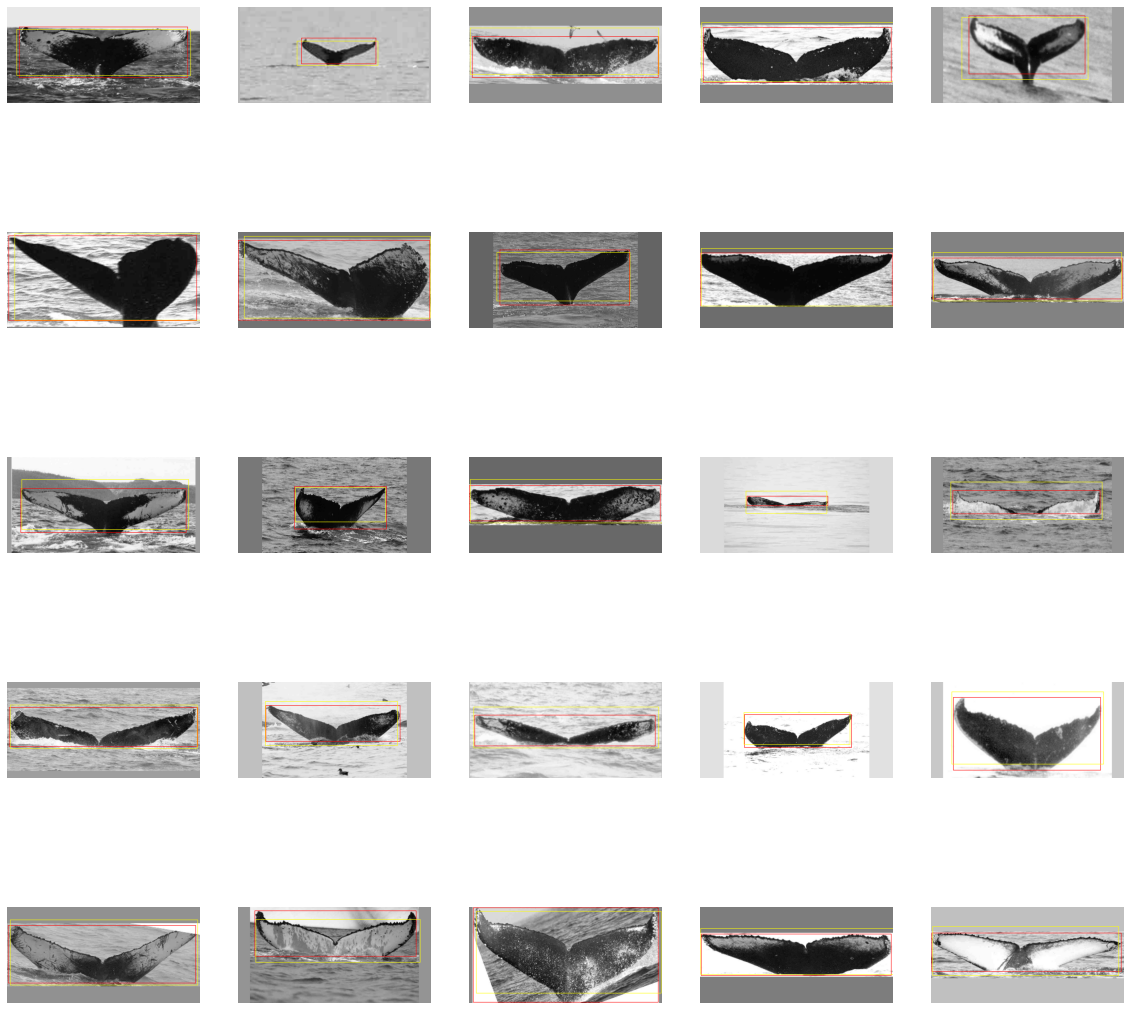

In [23]:
images = []
for i,(p,coords) in enumerate(val[:25]):
    a         = val_a[i:i+1]
    rect1     = val_b[i]
    rect2     = model2.predict(a).squeeze()
    img       = array_to_img(a[0]).convert('RGB')
    draw      = Draw(img)
    draw.rectangle(rect1, outline='red')
    draw.rectangle(rect2, outline='yellow')
    images.append(img)
show_whale(images)

# Generate best bounding boxes

In [45]:
DATA = '../input/train/'

In [46]:
from pandas import read_csv

tagged = [p for _,p,_ in read_csv('train.csv').to_records()]
submit = [p for _,p,_ in read_csv('sample_submission.csv').to_records()]
join = tagged + submit
len(join)

33321

In [47]:
# If the picture is part of the bounding box dataset, use the golden value.
p2bb = {}
for i,(p,coords) in enumerate(data): p2bb[p] = bounding_rectangle(coords)
len(p2bb)

1200

In [48]:
def expand_path(p):
    if isfile(DATA + p): return DATA + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

In [49]:
# For other pictures, evaluate the model.
p2bb = {}
for p in tqdm(join):
    if p not in p2bb:
        img,trans         = read_for_validation(p)
        a                 = np.expand_dims(img, axis=0)
        x0, y0, x1, y1    = model2.predict(a).squeeze()
        (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
        p2bb[p]           = (u0, v0, u1, v1)

 16%|█▌        | 5301/33321 [04:08<22:22, 20.87it/s]

KeyboardInterrupt: 

In [ ]:
import pickle

with open('bounding-box.pickle', 'wb') as f: pickle.dump(p2bb, f)

# Show some examples

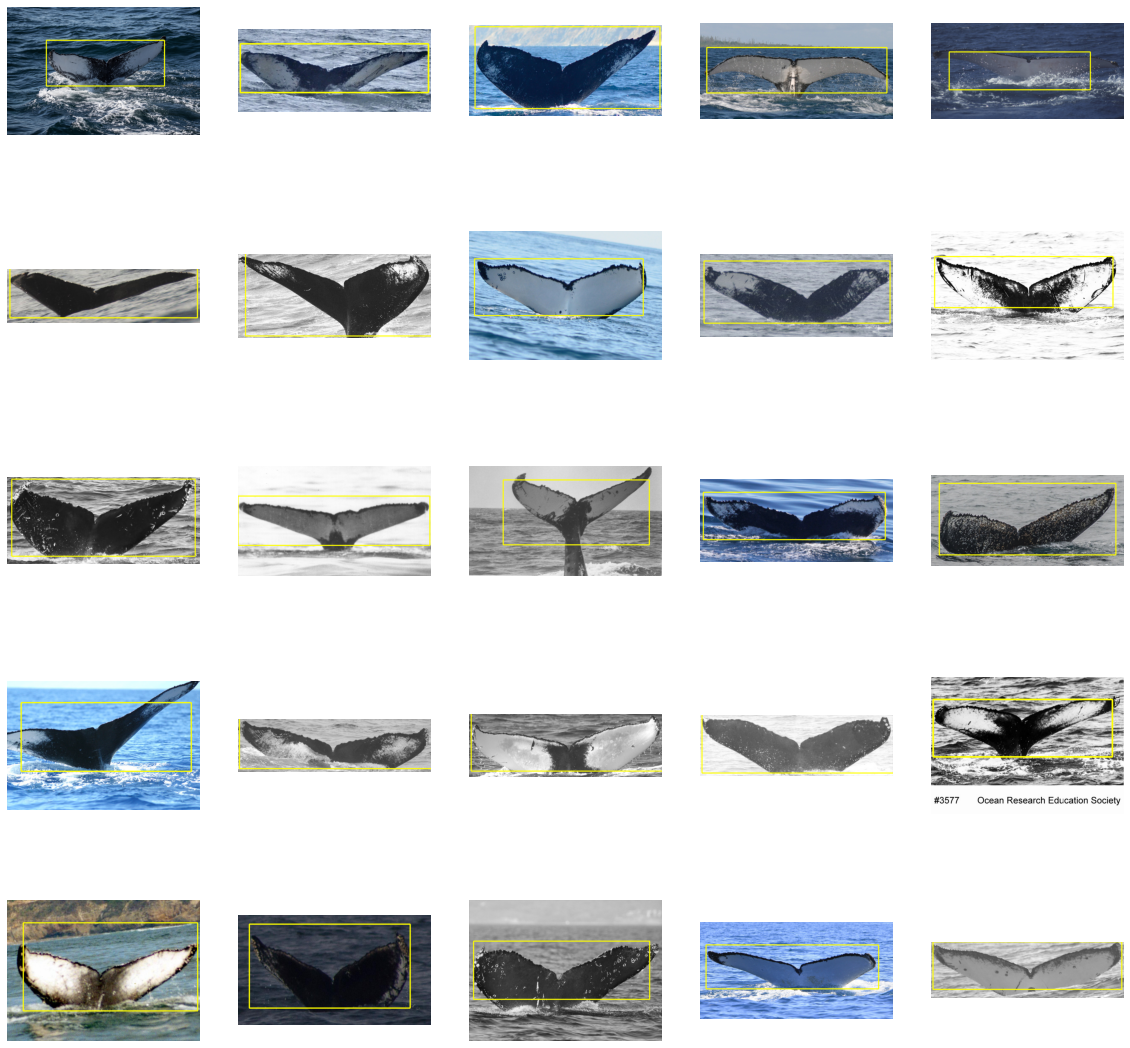

 16%|█▌        | 5301/33321 [04:20<22:22, 20.87it/s]

In [50]:
samples = []
for p in tagged[:25]:
    img         = read_raw_image(p).convert('RGB')
    draw        = Draw(img)
    x0,y0,x1,y1 = p2bb[p]
    draw.line([(x0, y0),(x0,y1),(x1,y1),(x1,y0),(x0,y0)], fill='yellow', width=6)
    samples.append(img)
show_whale(samples)

# Generated files

In [ ]:
import os

os.remove('cropping-1.h5')
os.remove('cropping-2.h5')
os.remove('cropping-3.h5')


In [ ]:
!ls *.pickle *.model